#**BRIEF**:
Our client, "Mrs Patricia Wang," wishes to purchase an OTC option on the company, SM Energy, whose stock is now trading at $232.90 USD:

She is also unsure about the level of maturity she wishes to consider when selecting this option.



**AVAILABLE:**

Information on vanilla options traded in the market, with the
underlying asset being the stock of SM in the attached CSV Excel file.

**REQUIRED:**

1, Calibrate a classic Heston (1993) model (without jumps) to the observed
   market prices for both call and put options using the Lewis (2001) approach with a regular MSE error function.

2, Double-check the different model parameters resulting from above        calibration repeating the same process above using the Carr-Madan (1999) pricing approach to calibrate the Heston (1993) model.

3, Price an ATM Asian call option for the client with 20 days maturity by
   obtaining the ‘fair price’ of the instrument using Monte-Carlo methods in a risk-neutral setting. Include a 4% charge fee on the price to obtain the final price that the client will end up paying.

4, Repeat the previous Task (1 above) using Carr-Madan (1999) approach to
   the Bates (1996) model.

5, Price a Put option on firm SM with 70 days maturity and moneyness of
   95% (i.e., strike is 95% of the current price).

6, Calibrate a CIR (1985) model using current Euribor rates and maturities
   using the cubic spline method to interpolate weekly rates for a period of 12 months (1year).

7, From the different CIR model parameters obtained in the step above, we
   must simulate 12-month daily Euribor rates for a period of 1 year by performing 100,000 Monte-Carlo simulations using a 95% level of confidence to reflect the range (min and max)

8, Calculate the expected value of the 12-month Euribor rate in a year's
   time, and compare it to the current 12-month Euribor rate to determine pricing implications.


#**INTRODUCTION:**


*   The Heston model is a prevalent stochastic volatility model in quantitative finance, designed to overcome a limitation of the Black-Scholes model in option markets by introducing the concept that the volatility of the underlying asset follows a stochastic process, specifically modeled by a square-root diffusion process.

*   The above definition reflects the observed volatility smile in option markets, allowing volatility to change dynamically over time.

*   The Heston model uses various parameters to predict volatility, including the long-term average volatility (θ), the speed of mean-reversion (κ), the volatility of volatility (σ), the correlation between asset price changes and volatility changes (ρ), and the initial volatility level (V0).

*   These parameters help capture the volatility process's tendency to revert to its long-term average over time.

*   Despite its limitations, the Heston model offers a closed-form solution for option pricing.

##Step 1(a)

We will start this process with importing all necessary libraries.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import brute, fmin
from scipy.optimize import minimize
from scipy.interpolate import splev, splrep
pd.options.mode.chained_assignment = None

##Then Define the early characteristic functions needed:
We will first start by deriving the characteristic function of Heston (1993) model by using the closed-form expression of the characteristic function of the H93 given by:

$$
\
\begin{equation*}
  \varphi^{H} (u, T) = e^{H_1(u, T)+H_2(u,T)\nu_0}
\end{equation*}
$$
\
where

$$
\
\begin{equation*}
  H_1 (u, T) \equiv r_0 uiT + \frac{c_1}{\sigma_\nu^2}\Biggl\{ (\kappa_\nu - \rho \sigma_\nu ui+c_2) T - 2 log \left[ \frac{1-c_3e^{c_2T}}{1-c_3} \right] \Biggl\}
\end{equation*}
$$
$$
\
\begin{equation*}
  H_2 (u, T) \equiv \frac{\kappa_\nu - \rho \sigma_\nu ui + c_2}{\sigma_\nu^2} \left[ \frac{1-e^{c_2T}}{1-c_3e^{c_2T}} \right]
\end{equation*}
$$
$$
\
\begin{equation*}
  c_1 \equiv \kappa_\nu \theta_\nu
\end{equation*}
$$
$$
\
\begin{equation*}
  c_2 \equiv - \sqrt{(\rho \sigma_\nu ui - \kappa_\nu)^2 - \sigma_\nu^2(-ui-u^2) }
\end{equation*}
$$
$$
\
\begin{equation*}
  c_3 \equiv \frac{\kappa_\nu - \rho \sigma_\nu ui + c_2}{\kappa_\nu - \rho \sigma_\nu ui - c_2}
\end{equation*}
$$

The derivation and closed-form expression for the characteristic function of the Classic Heston model above can be created with functions in Python that simplifies its calculations every time as seen below as well as for others:

In [ ]:
# H93 Char Function
def H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    """Fourier-based approach: characteristic function of H93 model via Lewis (2001)."""
    c1 = kappa_v * theta_v
    c2 = -np.sqrt(
        (rho * sigma_v * u * 1j - kappa_v) ** 2 - sigma_v**2 * (-u * 1j - u**2)
    )
    c3 = (kappa_v - rho * sigma_v * u * 1j + c2) / (
        kappa_v - rho * sigma_v * u * 1j - c2
    )
    H1 = r * u * 1j * T + (c1 / sigma_v**2) * (
        (kappa_v - rho * sigma_v * u * 1j + c2) * T
        - 2 * np.log((1 - c3 * np.exp(c2 * T)) / (1 - c3))
    )
    H2 = (
        (kappa_v - rho * sigma_v * u * 1j + c2)
        / sigma_v**2
        * ((1 - np.exp(c2 * T)) / (1 - c3 * np.exp(c2 * T)))
    )
    char_func_value = np.exp(H1 + H2 * v0)
    return char_func_value

We will also use the opportunity to define other characteristic functions that will be needed going forward. This includes:

Merton76

Merton76J (with Jump)

Bates96

Merton's (1976) characteristic function is given by:

$$
\begin{equation*}
    \varphi^{M76}_0 (u, T) = e^{\left( \left( i u \omega - \frac{u^2 \sigma^2}{2}+ \lambda ( e^{i u \mu_j - u^2 \delta^2/2}-1) \right) T \right)}
\end{equation*}
$$

where,

$$
\begin{equation*}
    \omega = r - \frac{\sigma^2}{2} - \lambda \left( e^{\mu_j + \delta^2/2}-1 \right)
\end{equation*}
$$

In [ ]:
# Merton 76 Characteristic function
def M76_char_func(u, T, r, sigma, lamb, mu, delta):
    """
    Characteristic function for Merton '76 model
    """
    omega = r - 0.5 * sigma**2 - lamb * (np.exp(mu + 0.5 * delta**2) - 1)
    char_func_value = np.exp(
        (
            1j * u * omega
            - 0.5 * u**2 * sigma**2
            + lamb * (np.exp(1j * u * mu - u**2 * delta**2 * 0.5) - 1)
        )
        * T
    )
    return char_func_value

The adjusted (only jump) characteristic function of Merton (1976) is given by:


$$
\
\begin{equation*}
    \varphi^{M76J}_0 (u, T) = e^{\left( \left( i u \omega + \lambda ( e^{i u \mu_j - u^2 \delta^2/2}-1) \right) T \right)}
\end{equation*}
$$

where,
$$
\
\begin{equation*}
    \omega = - \lambda \left( e^{\mu_j + \delta^2/2}-1 \right)
\end{equation*}
$$
\
Let's then code in this characteristic function:

In [ ]:
# M76J Characteristic Function
def M76J_char_func(u, T, lamb, mu, delta):
    """
    Adjusted Characteristic function for Merton '76 model: Only jump component
    """
    omega = -lamb * (np.exp(mu + 0.5 * delta**2) - 1)
    char_func_value = np.exp(
        (1j * u * omega + lamb * (np.exp(1j * u * mu - u**2 * delta**2 * 0.5) - 1))
        * T
    )
    return char_func_value

We already know that Bates (1996) model combines two desirable features: stochastic volatility of Heston (1993) and jump component from Merton (1976).

Thus, as we know, the characteristic function, $\varphi^{B96}( )$, of Bates (1996) is given by:

$$
\
\begin{equation*}
        \varphi^{B96}_0 (u, T) = \varphi^{H93}_0 \varphi^{M76J}_0 (u, T)
\end{equation*}
$$

\
where, $\varphi^{H93}_0$ stands for the characteristic function of Heston (1993).

In [ ]:
# B96 Characteristic Function
def B96_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    """
    Bates (1996) characteristic function
    """
    H93 = H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0)
    M76J = M76J_char_func(u, T, lamb, mu, delta)
    return H93 * M76J

We also need to obtain a value for the integral in Lewis (2001) for H93:

$$
\
\begin{equation*}
    C_0 = S_0 - \frac{\sqrt{S_0 K} e^{-rT}}{\pi} \int_{0}^{\infty} \mathbf{Re}[e^{izk} \varphi(z-i/2)] \frac{dz}{z^2+1/4}
\end{equation*}
$$


In [ ]:
# H93 Integral Function
def H93_int_func(u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    """
    Fourier-based approach for Lewis (2001): Integration function.
    """
    char_func_value = H93_char_func(
        u - 1j * 0.5, T, r, kappa_v, theta_v, sigma_v, rho, v0
    )
    int_func_value = (
        1 / (u**2 + 0.25) * (np.exp(1j * u * np.log(S0 / K)) * char_func_value).real
    )
    return int_func_value

The value of the aforementioned integral and its call value are then numerically computed using the quadrature method (*quad*) from the scipy package below.



In [ ]:
def H93_call_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    """Valuation of European call option in H93 model via Lewis (2001)

    Parameter definition:
    ==========
    S0: float
        initial stock/index level
    K: float
        strike price
    T: float
        time-to-maturity (for t=0)
    r: float
        constant risk-free short rate
    kappa_v: float
        mean-reversion factor
    theta_v: float
        long-run mean of variance
    sigma_v: float
        volatility of variance
    rho: float
        correlation between variance and stock/index level
    v0: float
        initial level of variance
    Returns
    =======
    call_value: float
        present value of European call option
    """
    int_value = quad(
        lambda u: H93_int_func(u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0),
        0,
        np.inf,
        limit=250,
    )[0]
    call_value = max(0, S0 - np.exp(-r * T) * np.sqrt(S0 * K) / np.pi * int_value)
    return call_value

As an alternative to Lewis (2001), we could use the FFT algorithm. Essentially, we may apply FFT to the integral in the call option price derived from Carr and Madan (1999):

$$
\
\begin{equation*}
    C_0 = \frac{e^{-\alpha \kappa}}{\pi} \int_{0}^{\infty} e^{-i\nu \kappa} \frac{e^{-rT} \varphi^{B96} (\nu - (\alpha + 1)i, T)}{\alpha^2 + \alpha - \nu^2 + i(2\alpha + 1)\nu} d\nu
\end{equation*}
$$
\
As with the Lewis (2001) approach, we must fundamentally modify the characteristic function under consideration to the Bates (1996) function.

In [ ]:
# Carr & Madan method
def H93_call_FFT(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    """
    Call option price in Bates (1996) under FFT
    """
    k = np.log(K / S0)
    g = 1 # Factor to increase accuracy
    N = g * 4096
    eps = (g * 150) ** -1
    eta = 2 * np.pi / (N * eps)
    b = 0.5 * N * eps - k
    u = np.arange(1, N + 1, 1)
    vo = eta * (u - 1)
    # Modifications to ensure integrability
    if S0 >= 0.95 * K: # ITM Case
        alpha = 1.5
        v = vo - (alpha + 1) * 1j
        modcharFunc = np.exp(-r * T) * (
            H93_char_func(v, T, r, kappa_v, theta_v, sigma_v, rho, v0)
            / (alpha**2 + alpha - vo**2 + 1j * (2 * alpha + 1) * vo)
        )
    else:
        alpha = 1.1
        v = (vo - 1j * alpha) - 1j
        modcharFunc1 = np.exp(-r * T) * (
            1 / (1 + 1j * (vo - 1j * alpha))
            - np.exp(r * T) / (1j * (vo - 1j * alpha))
            - H93_char_func(
                v, T, r, kappa_v, theta_v, sigma_v, rho, v0)
            / ((vo - 1j * alpha) ** 2 - 1j * (vo - 1j * alpha))
        )
        v = (vo + 1j * alpha) - 1j
        modcharFunc2 = np.exp(-r * T) * (
            1 / (1 + 1j * (vo + 1j * alpha))
            - np.exp(r * T) / (1j * (vo + 1j * alpha))
            - H93_char_func(
                v, T, r, kappa_v, theta_v, sigma_v, rho, v0
            )
            / ((vo + 1j * alpha) ** 2 - 1j * (vo + 1j * alpha))
        )
    # Numerical FFT Routine
    delt = np.zeros(N)
    delt[0] = 1
    j = np.arange(1, N + 1, 1)
    SimpsonW = (3 + (-1) ** j - delt) / 3
    if S0 >= 0.95 * K:
        FFTFunc = np.exp(1j * b * vo) * modcharFunc * eta * SimpsonW
        payoff = (np.fft.fft(FFTFunc)).real
        CallValueM = np.exp(-alpha * k) / np.pi * payoff
    else:
        FFTFunc = (
            np.exp(1j * b * vo) * (modcharFunc1 - modcharFunc2) * 0.5 * eta * Sim
        )
        payoff = (np.fft.fft(FFTFunc)).real
        CallValueM = payoff / (np.sinh(alpha * k) * np.pi)
    pos = int((k + b) / eps)
    CallValue = CallValueM[pos] * S0
    return CallValue

We then define the H93 Error Function

In [ ]:
def H93_error_function(p0, method):
    """Error function for parameter calibration via
    Lewis (2001) Fourier approach for Heston (1993).
    Parameters
    ==========
    kappa_v: float
        mean-reversion factor
    theta_v: float
        long-run mean of variance
    sigma_v: float
        volatility of variance
    rho: float
        correlation between variance and stock/index level
    v0: float
        initial, instantaneous variance
    Returns
    =======
    MSE: float
        mean squared error
    """
    global i, min_MSE
    kappa_v, theta_v, sigma_v, rho, v0 = p0
    if kappa_v < 0.0 or theta_v < 0.005 or sigma_v < 0.0 or rho < -1.0 or rho > 1.0:
        return 5000.0
    if 2 * kappa_v * theta_v < sigma_v**2:
        return 5000.0
    se = []
    for row, option in options.iterrows():
        model_value = method(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
        )
        se.append((model_value - option["Call"]) ** 2)
    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 200 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    return MSE

Next, we will need a function that optimizes the model parameters to minimize the error function in relation to market data.

We will perform this in two parts, first using the brute function of scipy to focus the calibration on the most sensible ranges, and then using the fmin function to extract the real values more accurately.


In [ ]:
def H93_calibration_full(method):
    """Calibrates Heston (1993) stochastic volatility model to market quotes."""
    # First run with brute force
    # (scan sensible regions, for faster convergence)
    p0 = brute(
        H93_error_function,
        (
            (2.5, 10.6, 5.0),  # kappa_v
            (0.01, 0.041, 0.01),  # theta_v
            (0.05, 0.251, 0.1),  # sigma_v
            (-0.75, 0.01, 0.25),  # rho
            (0.01, 0.031, 0.01),
        ),  # v0
        args = {method : method},
        finish=None,
    )
    # Second run with local, convex minimization
    # (we dig deeper where promising results)
    opt = fmin(
        H93_error_function, p0, args = (method,), xtol=0.000001, ftol=0.000001, maxiter=750, maxfun=900
    )
    return opt

Let us now attempt to Price with Heston (1993) via Lewis (2001) by first preparing the data using the downloaded file and other established parameters.


In [ ]:
data = pd.read_csv("/content/SM622_GWP1_Option data.xlsx - 1 (1).csv")
# Get and prepare the data
S0 = 232.90
T = 15/250
r = 0.015
def load_calibration_data(E):
    temp = data[(data["Days to maturity"] == E) & (data["Type"] == "C")]
    temp = pd.DataFrame({
        "Strike" : temp["Strike"],
        "Call" : temp["Price"],
        "T" : T,
        "r" : r
        })
    return temp

we confirm columns in the attached data

In [ ]:
print(data.columns)

Index(['Days to maturity', 'Strike', 'Price', 'Type'], dtype='object')


Step 1.(a) Heston Model using Lewis integral

We start our calibration process by introducing some more functions to optimize our model parameters such that they match observed market data.

The **mean squared error (MSE) function** will then be introduced, which evaluates the model's error with regard to observed data given specified parameters.


In [ ]:
i = 0
min_MSE = 5000
options = load_calibration_data(15)
diff_H_params_lewis = H93_calibration_full(H93_call_value)
print("Parameters using Lewis method %0.3f %0.3f %0.3f %0.3f %0.3f " %
        tuple(diff_H_params_lewis)
    )

   0 | [ 2.5   0.01  0.05 -0.75  0.01] |  23.560 |  23.560
 200 | [ 7.5   0.02  0.25 -0.25  0.03] |  12.271 |  11.079
 400 | [3.46731727 0.12439635 0.00694602 0.65657947 0.10353287] |   0.379 |   0.379


<ipython-input-7-277e0d7e46d1>:29: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  int_value = quad(


 600 | [3.04732415e+00 1.24756712e-01 4.10885546e-06 6.15621511e-01
 1.03350235e-01] |   0.378 |   0.378
 800 | [3.04732414e+00 1.24756711e-01 4.10870537e-06 6.15621485e-01
 1.03350234e-01] |   0.378 |   0.378
Optimization terminated successfully.
         Current function value: 0.377528
         Iterations: 281
         Function evaluations: 647
Parameters using Lewis method 3.047 0.125 0.000 0.616 0.103 


Now we have finally calibrated our parameters to market values.

The results from this calibration give us the following values for the parameters in the Heston (1993) model:

$\kappa_\nu = 3.047$

$\theta_\nu = 0.125$

$\sigma_\nu = 0.000$

$\rho = 0.616$

$\nu_0 = 0.103$

The next step will be simply using these parameters to price the option we want.

We then define the H93 function that calculates values under full model calibration:

In [ ]:
def H93_calculate_model_values(p0, method):
    kappa_v, theta_v, sigma_v, rho, v0= p0
    values = []
    for row, option in options.iterrows():
        model_value = method(
            S0,
            option["Strike"],
            option["T"],
            r,
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
        )
        values.append(model_value)
    return np.array(values)

We examine the differences produced by our model using the calibration parameters and compare them to observed market prices:


In [ ]:
def plot_full_calibration_results(p0, method):
    options["Model"] = H93_calculate_model_values(p0, method)
    plt.figure(figsize=(8, 6))
    plt.subplot(211)
    plt.grid()
    plt.title("Maturity %s Days" % str(int(options["T"].iloc[0]*250))[:10])
    plt.ylabel("option values")
    plt.plot(options.Strike, options.Call, "b", label="market")
    plt.plot(options.Strike, options.Model, "ro", label="model")
    plt.legend(loc=0)
    plt.axis(
        [
            min(options.Strike) - 5,
            max(options.Strike) + 5,
            min(options.Call) - 10,
            max(options.Call) + 10,
        ]
    )
    plt.subplot(212)
    plt.xlabel("Strike")
    plt.grid()
    wi = 2
    diffs = options.Model.values - options.Call.values
    plt.bar(options.Strike.values - wi / 2, diffs, width=wi)
    plt.ylabel("difference")
    plt.axis(
        [
            min(options.Strike) - 5,
            max(options.Strike) + 5,
            min(diffs) * 1.1,
            max(diffs) * 1.1,
        ]
    )
    plt.tight_layout()

As you can see, the model perform better in terms of fitting the observed option market prices after the full calibration process.

<ipython-input-7-277e0d7e46d1>:29: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  int_value = quad(


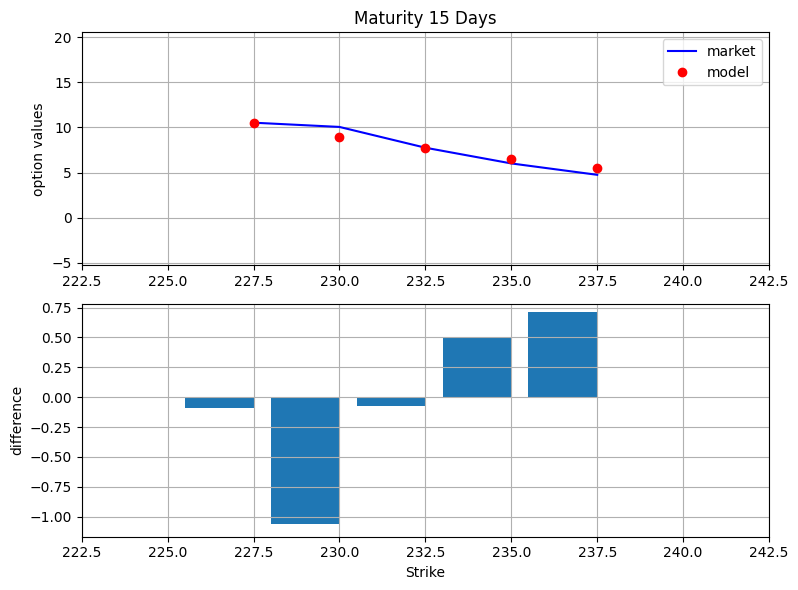

In [ ]:
plot_full_calibration_results(diff_H_params_lewis, H93_call_value)

From all what we have done , we have shown how the Lewis 2001 method aids the calculation of the price of the option as shown on the graph above.

To calibrate the parameters gotten above, we applied the brute method with the possible range of the parameters and then refined our search to precision using the initial values. Since we would also like to price an ATM put option with 15 days  maturity, we used the price of the option with similar Maturity and Strike.




##Step 1.(b) Heston model Carr and Madan FFT method.


As an alternative to Lewis (2001), we could also implement the FFT algorithm. Essentially, we can apply FFT to the integral in the call option price derived by Carr and Madan (1999):
$$
\
\begin{equation*}
    C_0 = \frac{e^{-\alpha \kappa}}{\pi} \int_{0}^{\infty} e^{-i\nu \kappa} \frac{e^{-rT} \varphi^{B96} (\nu - (\alpha + 1)i, T)}{\alpha^2 + \alpha - \nu^2 + i(2\alpha + 1)\nu} d\nu
\end{equation*}
$$
\
Here we are going to use the same numerical routine we implemented in Module 1; please go there for more information. As was the case with the Lewis (2001) approach, we basically have to adapt the characteristic function we are considering to be the Bates (1996) one.

In [ ]:
i = 0
min_MSE = 5000.00
diff_H_params_fft = H93_calibration_full(H93_call_FFT)
print("\n\n")
print("*****************************************")
print("Parameters using Carrr & Madan method %0.3f %0.3f %0.3f %0.3f %0.3f " % tuple (diff_H_params_fft))
print("\n\n")

   0 | [ 2.5   0.01  0.05 -0.75  0.01] |  23.560 |  23.560
 200 | [ 7.5   0.02  0.25 -0.25  0.03] |  12.271 |  11.079
 400 | [3.46731727 0.12439635 0.00694602 0.65657947 0.10353287] |   0.379 |   0.379
 600 | [3.04956975e+00 1.24757951e-01 2.01570798e-07 6.14219841e-01
 1.03338331e-01] |   0.377 |   0.377
 800 | [3.04956998e+00 1.24757954e-01 2.01671261e-07 6.14219790e-01
 1.03338332e-01] |   0.377 |   0.376
Optimization terminated successfully.
         Current function value: 0.376370
         Iterations: 300
         Function evaluations: 692



*****************************************
Parameters using Carrr & Madan method 3.050 0.125 0.000 0.614 0.103 





Now we have finally calibrated our parameters to market values using the Carrr and Madan method 1999.

The results from this calibration give us almost the exact same values in some parameters earlier obtained using the Lewis 2001 method. The following values for the parameters using Carr & Madan method pricing approach to calibrate the Heston (1993)
model:

$\kappa_\nu = 3.050$

$\theta_\nu = 0.125$

$\sigma_\nu = 0.000$

$\rho = 0.614$

$\nu_0 = 0.103$

<ipython-input-7-277e0d7e46d1>:29: IntegrationWarning: The maximum number of subdivisions (250) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  int_value = quad(


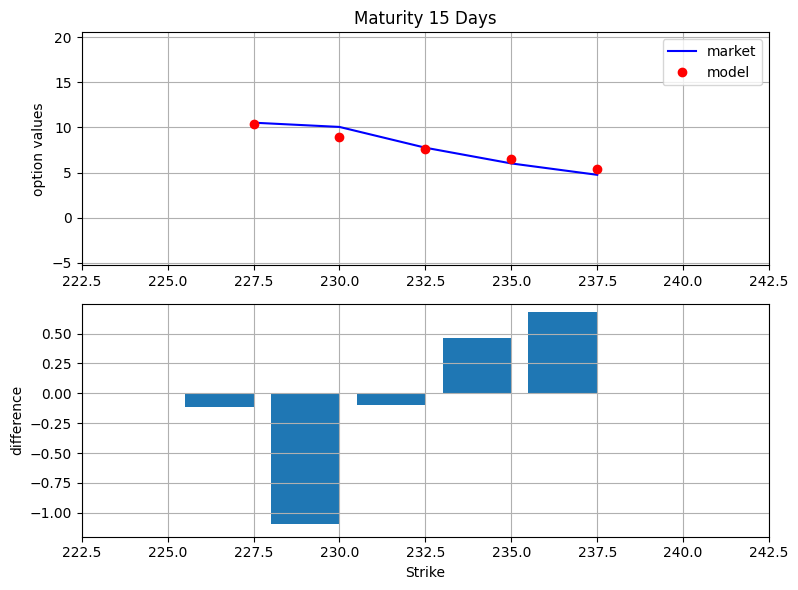

In [ ]:
plot_full_calibration_results(diff_H_params_fft , H93_call_value)

###Step 1.(c) Asian option pricing using Heston Model


We will price the ATM Asian call option for the client using 20 days maturity by obtaining the ‘fair price’ of the instrument using Heston Monte-Carlo methods in a
risk-neutral setting with enough simulations in
Monte-Carlo.

We will be first replicating the code on how to simulate underlying stock prices under the following Heston dynamics:
$$
\begin{equation*}
    S_t = S_{t-1} e^{\left( r - \frac{\nu_t}{2} \right) dt + \sigma \sqrt{\nu_t} dZ_1}
\end{equation*}
$$
$$
\begin{equation*}
    \nu_t = \nu_{t-1} + \kappa \left( \theta - \nu_{t-1} \right) dt + \sigma \sqrt{\nu_{t-1}}dZ_2
\end{equation*}
$$


First we will define and run the different functions we needed to simulate stock prices by stochastic volatility:

In [ ]:
def SDE_vol(v0, kappa, theta, sigma, T, M, Ite, rand, row, cho_matrix):
    dt = T / M  # T = maturity, M = number of time steps
    v = np.zeros((M + 1, Ite), dtype=np.float32)
    v[0] = v0
    sdt = np.sqrt(dt)  # Sqrt of dt
    for t in range(1, M + 1):
        ran = np.dot(cho_matrix, rand[:, t])
        v[t] = np.maximum(
            0,
            v[t - 1]
            + kappa * (theta - v[t - 1]) * dt
            + np.sqrt(v[t - 1]) * sigma * ran[row] * sdt,
        )
    return v

Then the underlying stock price path based on stochastic vol:

In [ ]:
def Heston_paths(S0, r, v, row, cho_matrix, rand, M, dt, Ite):
    S = np.zeros((M + 1, Ite), dtype=np.float32)
    S[0] = S0
    sdt = np.sqrt(dt)
    for t in range(1, M + 1, 1):
        ran = np.dot(cho_matrix, rand[:, t])
        S[t] = S[t - 1] * np.exp((r - 0.5 * v[t]) * dt + np.sqrt(v[t]) * ran[row] * sdt)
    return S


We then define the function to generate random numbers following a standard normal:

In [ ]:
def random_number_gen(M, Ite):
    rand = np.random.standard_normal((2, M + 1, Ite))
    return rand

And build our covariance matrix (using Cholesky decomposition to account for correlation between  𝑑𝑍1
and  𝑑𝑍2) and simulate the stock price paths and stochastic volatility:

In [ ]:
def asian_opt_call(S0, K, r, T, params):
    kappa_v , theta_v, sigma_v, rho, v0 = tuple(params)
    M0 = 250 # Number of time steps in a year
    T = T/M0
    M = int(M0 * T) # Total time steps
    Ite = 10**5 # Number of simulations
    dt = T / M # Length of time step
    # Generating random numbers from standard normal
    rand = random_number_gen(M, Ite)
    # Covariance Matrix
    covariance_matrix = np.zeros((2, 2), dtype=np.float32)
    covariance_matrix[0] = [1.0, rho]
    covariance_matrix[1] = [rho, 1.0]
    cho_matrix = np.linalg.cholesky(covariance_matrix)
    # Volatility process paths
    V = SDE_vol(v0, kappa_v, theta_v, sigma_v, T, M, Ite, rand, 1, cho_matrix)
    # Underlying price process path
    S = Heston_paths(S0, r, V, 0, cho_matrix, rand, M, dt, Ite)
    # call_asian = np.maximum(S.mean(axis=0) - K, 0).mean()
    put_asian = np.maximum(-S.mean(axis=0) + K, 0).mean()
    return put_asian
put = asian_opt_call(S0, S0, r, 20, diff_H_params_fft)
print("The put price is $%.2f"%put)
print("With 4%% service charge, the price is $%.2f"% (put*1.04))


The put price is $4.77
With 4% service charge, the price is $4.96


##Step 2

Since the client seems hesitant about the short maturity considered in step 1, we will examine her thoughts of an instrument with 60 days maturity and see if it would be better adapted to her needs.

Let's start by setting calibration parameters and defining the error function, which obviously will be looking at the differences between market and model prices for the complete Bates (1996) model:

In [ ]:
i = 0
min_MSE = 5000.0
local_opt = False

We already know that Bates (1996) model combines two desirable features: stochastic volatility of Heston (1993) and jump component from Merton (1976).

Thus, as we know, the characteristic function, $\varphi^{B96}( )$, of Bates (1996) is given by:

$$
\
\begin{equation*}
        \varphi^{B96}_0 (u, T) = \varphi^{H93}_0 \varphi^{M76J}_0 (u, T)
\end{equation*}
$$

\
As we also know, $\varphi^{H93}_0$ stands for the characteristic function of Heston (1993).

In [ ]:
def B96_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    """
    Bates (1996) characteristic function
    """
    H93 = H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0)
    M76J = M76J_char_func(u, T, lamb, mu, delta)
    return H93 * M76J

We will start by calculating the value of the Lewis (2001) integral for the specific case of the Bates (1996) characteristic function:

In [ ]:
def B96_int_func(u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    """
    Lewis (2001) integral value for Bates (1996) characteristic function
    """
    char_func_value = B96_char_func(
        u - 1j * 0.5, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta
    )
    int_func_value = (
        1 / (u**2 + 0.25) * (np.exp(1j * u * np.log(S0 / K)) * char_func_value).real
    )
    return int_func_value

###Now, for this error function to be able to compute model option prices, we also need to import or load the different functions used in the pricing via Bates (1996) model. First, for the value of the option:

In [ ]:
def B96_call_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    """
    Valuation of European call option in B96 Model via Lewis (2001)
    Parameters:
    ==========
    S0: float
        initial stock/index level
    K: float
        strike price
    T: float
        time-to-maturity (for t=0)
    r: float
        constant risk-free short rate
    kappa_v: float
        mean-reversion factor
    theta_v: float
        long-run mean of variance
    sigma_v: float
        volatility of variance
    rho: float
        correlation between variance and stock/index level
    v0: float
        initial level of variance
    lamb: float
        jump intensity
    mu: float
        expected jump size
    delta: float
        standard deviation of jump
    ==========
    """
    int_value = quad(
        lambda u: B96_int_func(
            u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta
        ),
        0,
        np.inf,
        limit=250,
    )[0]
    call_value = max(0, S0 - np.exp(-r * T) * np.sqrt(S0 * K) / np.pi * int_value)
    return call_value

As an alternative to Lewis (2001) method, we could also implement the FFT algorithm to the integral in the call option price derived by Carr and Madan (1999):
$$
\
\begin{equation*}
    C_0 = \frac{e^{-\alpha \kappa}}{\pi} \int_{0}^{\infty} e^{-i\nu \kappa} \frac{e^{-rT} \varphi^{B96} (\nu - (\alpha + 1)i, T)}{\alpha^2 + \alpha - \nu^2 + i(2\alpha + 1)\nu} d\nu
\end{equation*}
$$
\
We use the same numerical routine above to adapt the characteristic function we are considering to be the Bates (1996) one.

In [ ]:
def B96_call_FFT(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    """
    Call option price in Bates (1996) under FFT
    """

    k = np.log(K / S0)
    g = 1  # Factor to increase accuracy
    N = g * 4096
    eps = (g * 150) ** -1
    eta = 2 * np.pi / (N * eps)
    b = 0.5 * N * eps - k
    u = np.arange(1, N + 1, 1)
    vo = eta * (u - 1)

    # Modifications to ensure integrability
    if S0 >= 0.95 * K:  # ITM Case
        alpha = 1.5
        v = vo - (alpha + 1) * 1j
        modcharFunc = np.exp(-r * T) * (
            B96_char_func(v, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta)
            / (alpha**2 + alpha - vo**2 + 1j * (2 * alpha + 1) * vo)
        )

    else:
        alpha = 1.1
        v = (vo - 1j * alpha) - 1j
        modcharFunc1 = np.exp(-r * T) * (
            1 / (1 + 1j * (vo - 1j * alpha))
            - np.exp(r * T) / (1j * (vo - 1j * alpha))
            - B96_char_func(
                v, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta
            )
            / ((vo - 1j * alpha) ** 2 - 1j * (vo - 1j * alpha))
        )

        v = (vo + 1j * alpha) - 1j

        modcharFunc2 = np.exp(-r * T) * (
            1 / (1 + 1j * (vo + 1j * alpha))
            - np.exp(r * T) / (1j * (vo + 1j * alpha))
            - B96_char_func(
                v, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta
            )
            / ((vo + 1j * alpha) ** 2 - 1j * (vo + 1j * alpha))
        )

    # Numerical FFT Routine
    delt = np.zeros(N)
    delt[0] = 1
    j = np.arange(1, N + 1, 1)
    SimpsonW = (3 + (-1) ** j - delt) / 3
    if S0 >= 0.95 * K:
        FFTFunc = np.exp(1j * b * vo) * modcharFunc * eta * SimpsonW
        payoff = (np.fft.fft(FFTFunc)).real
        CallValueM = np.exp(-alpha * k) / np.pi * payoff
    else:
        FFTFunc = (
            np.exp(1j * b * vo) * (modcharFunc1 - modcharFunc2) * 0.5 * eta * SimpsonW
        )
        payoff = (np.fft.fft(FFTFunc)).real
        CallValueM = payoff / (np.sinh(alpha * k) * np.pi)

    pos = int((k + b) / eps)
    CallValue = CallValueM[pos] * S0

    return CallValue

In [ ]:
def B96_error_function(p0, method):
    """
    Error function for Bates (1996) model

    Parameters:
    -------------
    lamb: float
        jump intensity
    mu: float
        expected jump size
    delta: float
        standard deviation of jump
    Returns
    -------------
    MSE: float
        mean squared error
    """

    global i, min_MSE, local_opt, opt1
    lamb, mu, delta = p0
    if lamb < 0.0 or mu < -0.6 or mu > 0.0 or delta < 0.0:
        return 5000.0
    se = []
    for row, option in options.iterrows():
        model_value = method(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
        )
        se.append((model_value - option["Call"]) ** 2)
    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 200 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    if local_opt:
        penalty = np.sqrt(np.sum((p0 - opt1) ** 2)) * 1
        return MSE + penalty
    return MSE

We then build up a B96_full_error_function that essentially takes these inputs and calculate the error function where we do not impose any penalties on the error function, as it solves an inherent problem of the jump diffusion model that should be already solved by using the initial inputs from the jump component calibration.

In [ ]:
def B96_full_error_function(p0, method):
    global i, min_MSE
    kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta = p0

    if (
        kappa_v < 0.0
        or theta_v < 0.005
        or sigma_v < 0.0
        or rho < -1.0
        or rho > 1.0
        or v0 < 0.0
        or lamb < 0.0
        or mu < -0.6
        or mu > 0.0
        or delta < 0.0
    ):
        return 5000.0

    if 2 * kappa_v * theta_v < sigma_v**2:
        return 5000.0

    se = []
    for row, option in options.iterrows():
        model_value = method(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
        )
        se.append((model_value - option["Call"]) ** 2)

    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 200 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    return MSE

And then of course for the different characteristic functions and computation of the Lewis (2001) integral which we had already done earlier:

Then, we create our functions to calibrate the jump component of the model by starting with the B96_Calibration_Short:

In [ ]:
def B96_calibration_short(method):
    """
    Calibrates jump component of Bates (1996) model to market prices
    """
    # First, we run with brute force
    # (scan sensible regions)
    opt1 = 0.0
    opt1 = brute(
        B96_error_function,
        (
            (0.0, 0.51, 0.1),  # lambda
            (-0.5, -0.11, 0.1),  # mu
            (0.0, 0.51, 0.25),   # delta
        ),
        args= {method : method},
        finish=None,
    )
    # Second, we run with local, convex minimization
    # (dig deeper where promising)
    opt2 = fmin(
        B96_error_function,
        opt1,
        args = (method,),
        xtol=0.0000001,
        ftol=0.0000001,
        maxiter=550,
        maxfun=750,
    )
    return opt2

In [ ]:
def B96_calibration_full(method):
    opt = fmin(
        B96_full_error_function, p0, args=(method,), xtol=0.001, ftol=0.001, maxiter=1250, maxfun=750
    )
    return opt

##Step 2 (a) The Bates model - Lewis method


In [ ]:
################# Load the Data for calibration ########################
S0 = 232.90
T = 60/250
r = 0.015
options = load_calibration_data(60)

In [ ]:
 ##Get our Heston jump parameters
i = 0
min_MSE = 5000.0
local_opt = False
diff_H_params_fftcm = H93_calibration_full(H93_call_FFT)
kappa_v, theta_v, sigma_v, rho, v0 = tuple(diff_H_params_fftcm)

   0 | [ 2.5   0.01  0.05 -0.75  0.01] | 124.804 | 124.804
 200 | [ 7.5   0.02  0.25 -0.25  0.03] |  76.370 |  58.668
 400 | [ 1.49306141e+01  1.49025368e-01  1.01412528e-03 -7.09866761e-03
  4.80491047e-02] |   1.264 |   1.264
Optimization terminated successfully.
         Current function value: 1.264124
         Iterations: 132
         Function evaluations: 265


In [ ]:
##Calibrate the jump parameters
jump_params_lewis = B96_calibration_short(B96_call_value)
p0 = np.hstack([diff_H_params_fftcm, jump_params_lewis])


 600 | [ 2.5e-04 -5.0e-01  0.0e+00] |   1.264 |   1.264
Optimization terminated successfully.
         Current function value: 1.264124
         Iterations: 58
         Function evaluations: 170


In [ ]:
i = 0
min_MSE = 5000.0
################### calibrate full paramteres ###########################
bates_full_params_lewis = B96_calibration_full(B96_call_value)
print("\n\n")
print("Bates Lewis Parameter %.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f " % tuple(bates_full_params_lewis))

   0 | [ 1.49302920e+01  1.49011019e-01  1.01196118e-03 -7.09423428e-03
  4.80231862e-02  5.91171556e-15 -5.03645833e-01  3.64583333e-05] |   1.264 |   1.264


<ipython-input-26-e06401f36e4a>:32: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  int_value = quad(


Optimization terminated successfully.
         Current function value: 1.264043
         Iterations: 104
         Function evaluations: 198



Bates Lewis Parameter 14.932 0.149 0.000 -0.006 0.048 0.000 -0.587 0.000 


Estimated parameters

𝜅𝑣 = 14.932

𝜃𝑣 = 0.149

𝜎𝑣 = 0.000

𝜌 = −0.006

𝑣0 = 0.048

𝜆 = 0.000

𝜇 = −0.587

𝛿 = 0.000

And, finally, a function to calculate values under full model calibration:

In [ ]:
def B96_calculate_model_values(p0, method):
    kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta = p0
    values = []
    for row, option in options.iterrows():
        model_value = method(
            S0,
            option["Strike"],
            option["T"],
            r,
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
        )
        values.append(model_value)
    return np.array(values)

In [ ]:
def plot_full_calibration_results(p0, method):
    options["Model"] = B96_calculate_model_values(p0, method)
    plt.figure(figsize=(8, 6))
    plt.subplot(211)
    plt.grid()
    plt.title("Maturity %s" % str(int(250*options["T"].iloc[0]))[:10])
    plt.ylabel("option values")
    plt.plot(options.Strike, options.Call, "b", label="market")
    plt.plot(options.Strike, options.Model, "ro", label="model")
    plt.legend(loc=0)
    plt.axis(
        [
            min(options.Strike) - 5,
            max(options.Strike) + 5,
            min(options.Call) - 10,
            max(options.Call) + 10,
        ]
    )
    plt.subplot(212)
    plt.grid()
    wi = 2.0
    diffs = options.Model.values - options.Call.values
    plt.bar(options.Strike.values - wi / 2, diffs, width=wi)
    plt.ylabel("difference")
    plt.xlabel("Strike")
    plt.axis(
        [
            min(options.Strike) - 5,
            max(options.Strike) + 5,
            min(diffs) * 1.1,
            max(diffs) * 1.1,
        ]
    )
    plt.tight_layout()


<ipython-input-26-e06401f36e4a>:32: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  int_value = quad(


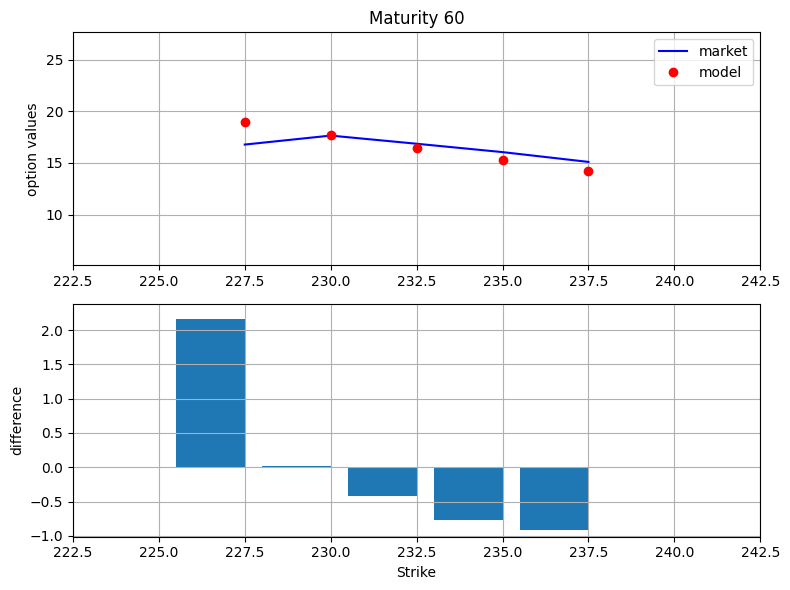

In [ ]:
plot_full_calibration_results(bates_full_params_lewis, B96_call_value)

##Step 2(b) Using Carr-Madan(1999) approach to Bates (1996) model.

In [ ]:
i = 0
min_MSE = 5000.0
local_opt = False
######### reset the Heston stochastic volatility parameters ##############
kappa_v, theta_v, sigma_v, rho, v0 = tuple(diff_H_params_fftcm)
jump_params_fftmc = B96_calibration_short(B96_call_FFT)
p0 = np.hstack([diff_H_params_fftcm, jump_params_fftmc])

   0 | [ 0.  -0.5  0. ] |   1.264 |   1.264
 200 | [ 4.54745809e-16 -5.08332966e-01  8.33343223e-05] |   1.264 |   1.264
Optimization terminated successfully.
         Current function value: 1.264124
         Iterations: 63
         Function evaluations: 180


In [ ]:
i = 0
min_MSE = 5000.0
bates_full_params_fft = B96_calibration_full(B96_call_FFT)
print("\n\n")
print("Bates Lewis Parameter %.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f" % tuple(bates_full_params_fft))

   0 | [ 1.49302920e+01  1.49011019e-01  1.01196118e-03 -7.09423428e-03
  4.80231862e-02  4.54747351e-16 -5.08333333e-01  8.33333333e-05] |   1.264 |   1.264
Optimization terminated successfully.
         Current function value: 1.264109
         Iterations: 107
         Function evaluations: 212



Bates Lewis Parameter 14.871 0.149 0.000 -0.007 0.048 0.000 -0.572 0.000


Estimated parameters

𝜅𝑣 = 14.871

𝜃𝑣 = 0.149

𝜎𝑣 = 0.000

𝜌 = −0.007

𝑣0 = 0.048

𝜆 = 0.000

𝜇 = −0.572

𝛿 = 0.000

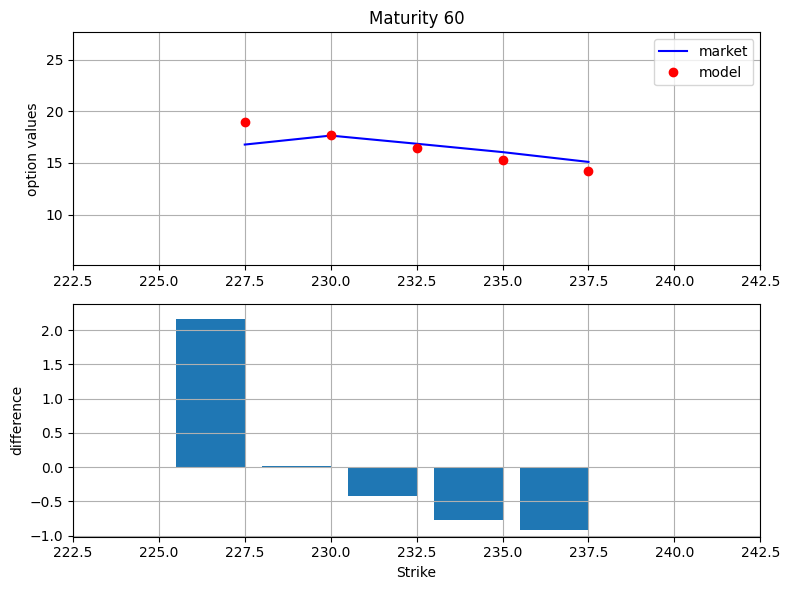

In [ ]:
plot_full_calibration_results(bates_full_params_lewis, B96_call_FFT)

##Step 2(c) Pricing a put option on firm SM with 70 days maturity and moneyness of 95% (i.e., strike is 95% of the current price).

In [ ]:
def SDE_bates_vol(v0, kappa, theta, sigma, T, M, Ite, rand, row, cho_matrix):
    dt = T / M # T = maturity, M = number of time steps
    v = np.zeros((M + 1, Ite), dtype=np.float32)
    v[0] = v0
    sdt = np.sqrt(dt) # Sqrt of dt
    for t in range(1, M + 1):
        ran = np.dot(cho_matrix, rand[:, t])
        v[t] = np.maximum(
            0,
            v[t - 1]
            + kappa * (theta - v[t - 1]) * dt
            + np.sqrt(v[t - 1]) * sigma * (ran[row] * sdt)**2
        )
    return v

In [ ]:
def Bates_paths(S0, r, v, row, lamb, mu, delta, cho_matrix, rand, M, dt, Ite):
    S = np.zeros((M + 1, Ite), dtype=np.float32)
    S[0] = S0
    sdt = np.sqrt(dt)
    rj = lamb * (np.exp(mu + 0.5 * delta**2) - 1) # rj
    # Random numbers
    Jt = np.exp(np.random.normal(np.log( 1 + mu ) - 0.5 * delta ** 2, delta ** 2, size=(M + 1, Ite)))
    Nt = np.random.poisson(lamb * dt, (M + 1, Ite))
    for t in range(1, M + 1):
        ran = np.dot(cho_matrix, rand[:, t])
        S[t] = S[t - 1] * (1 +
                           (r - rj) * dt + np.sqrt(v[t]) * ran[row] * sdt + Jt[t] * Nt[t])
        S[t] = np.maximum(S[t], 0.00001) # To ensure that the price never goes below 0.
    return S

In [ ]:
def random_number_gen(M, Ite):
    rand = np.random.standard_normal((2, M + 1, Ite))
    return rand

In [ ]:
def bates_asian_opt_call(S0, K, r, T, params):
    kappa_v , theta_v, sigma_v, rho, v0, lamb, mu, delta = tuple(params)
    M0 = 250 # Number of time steps in a year
    M = int(M0 * T) # Total time steps
    Ite = 10**5 # Number of simulations
    dt = T / M # Length of time step
    # Generating random numbers from standard normal
    rand = random_number_gen(M, Ite)
    # Covariance Matrix
    covariance_matrix = np.zeros((2, 2), dtype=np.float32)
    covariance_matrix[0] = [1.0, rho]
    covariance_matrix[1] = [rho, 1.0]
    cho_matrix = np.linalg.cholesky(covariance_matrix)
    # Volatility process paths
    V = SDE_bates_vol(v0, kappa_v, theta_v, sigma_v, T, M, Ite, rand, 1, cho_matrix)
    # Underlying price process paths
    S = Bates_paths(S0, r, V, 0, lamb, mu, delta, cho_matrix, rand, M, dt, Ite)
    put_asian = np.maximum( -S.mean(axis=0) + K, 0).mean()
    return put_asian
bates_put = bates_asian_opt_call(S0, S0*0.95, r, 70/250, bates_full_params_fft)
print("The Asian Put price is $%.2f" %bates_put)
kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta = tuple(bates_full_params_lewis)
cp = B96_call_FFT(S0, S0*0.95, 70/250, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta)
put_european = cp + S0*0.95 * np.exp(-70/250*r) - S0
print("The European Put price is $%.2f" % put_european)

The Asian Put price is $4.12
The European Put price is $11.35


#Step 3

##Step 3(a) Calibrate a CIR (1985) model considering current rates, describing the overall process.

The first task that we need to complete is to get the Euribor (risk-free) Current rates for different maturities (in days, weeks, days, Months, years all divided by 360 to express it as a fraction of years)

Euribor 1 Week          ======== 0.648%

Euribor 1 Month         ======= 0.679%

Euribor 3 Months        ====== 1.173%

Euribor 6 Months        ====== 1.809%

Euribor 12 Months       ===== 2.556%

In [ ]:
mat_list = np.array((7, 30, 90, 180, 360)) / 360
rate_list = (
 np.array((0.648, 0.679, 1.173, 1.809, 2.556)) / 100
)

Next, we have to build up the valuation of bonds according to the Cox-Ingersoll-Ross model of 1985.

The CIR model has the following general SDE:
$$
\
\begin{equation*}
  dr_t = k_r(\theta_r-r_t)dt + \sigma_r \sqrt{r_t} dz_t
\end{equation*}
$$
\
In this model, prices of ZCBs paying 1 monetary unit at T take the following form:
$$
\
\begin{equation*}
        B_0(T) = b_1(T) e^{-b_2(T)r_0}
\end{equation*}
$$

let's define the current short-term rate ( 𝑟0
 ), the capitalization factors and the zero-forward rates implied by the Euribor rates observed in the market. (Note that we are using 30/360 convention for the rates since this is the way Euribor--and most rates remain quoted)

In [ ]:
r0 = rate_list[0]
factors = 1 + mat_list * rate_list
zero_rates = 1 / mat_list * np.log(factors)
zero_rates

array([0.00647959, 0.00678808, 0.01171283, 0.01800868, 0.0252388 ])

Let's plot our forward rates (from  𝑡=0
 ) and the different maturities:

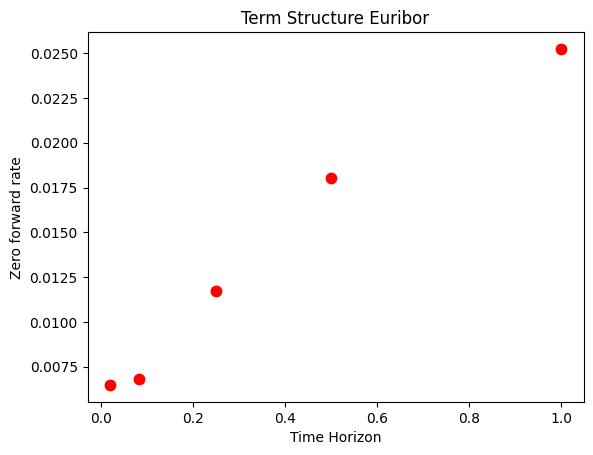

In [ ]:
plt.plot(mat_list, zero_rates, "r.", markersize="15")
plt.xlabel("Time Horizon")
plt.ylabel("Zero forward rate")
plt.title("Term Structure Euribor")
plt.show()

Unfortunately, as we observed in the previous graph, there are a limited amount of rates quoted in the market. However, in order to calibrate the parameters within our model, we would prefer to have as many inputs (data points) as possible by using one common solution to this:

By interpolating the term structure of forward rates consisting of fitting a function that can replicate the observed term structure and infer what the forward rate of a given maturity for which there is no market quote is using a common way of interpolation, called the cubic spline interpolation.

In [ ]:
bspline = splrep(mat_list, zero_rates, k=3) # Cubic spline
mat_list_n = np.linspace(
 0.0, 1.0, 52
) # weekly rates
inter_rates = splev(mat_list_n, bspline, der=0) # Interpolated rates
first_der = splev(mat_list_n, bspline, der=1) # First derivative of spline
f = (
 inter_rates + first_der * mat_list_n
) # Forward rate given interpolated ones and first derivative

Now, let's compare the output of our interpolation with the observed market quotes:

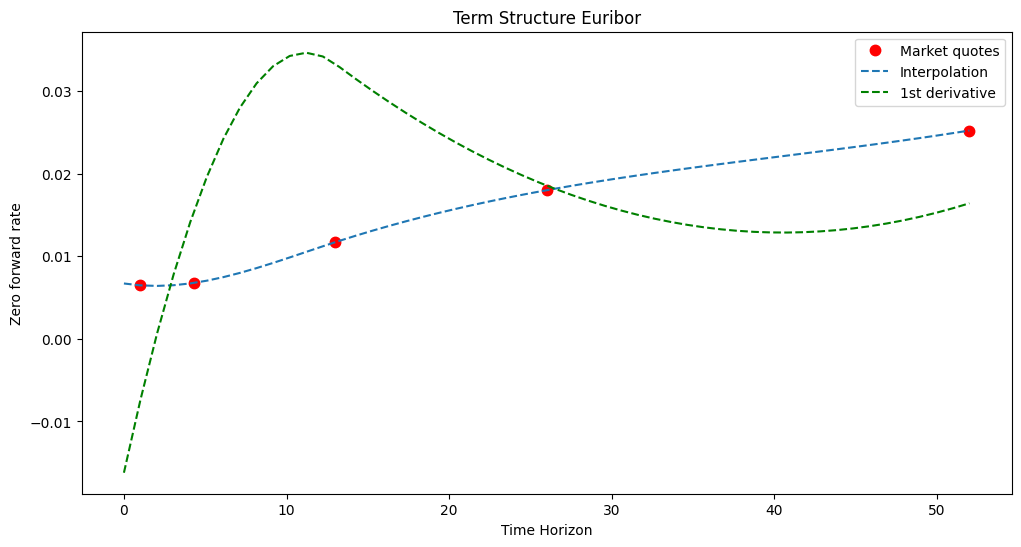

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(mat_list*52, zero_rates, "r.", markersize="15", label="Market quotes")
plt.plot(mat_list_n*52, inter_rates, "--", markersize="10", label="Interpolation")
plt.plot(mat_list_n*52, first_der, "g--", markersize="10", label="1st derivative")
plt.xlabel("Time Horizon")
plt.ylabel("Zero forward rate")
plt.title("Term Structure Euribor")
plt.legend()
plt.show()

From the graph, we seem pretty close. In turn, we have many more data points that we can use to calibrate our interest rate model to observed (or, better said, interpolated from observed) market quotes.

We will calibrate forward rates of the CIR (1985) model defining in Python the forward rate expression in the CIR model, $f^{CIR}(t,T; \alpha)$. Remember that we have already seen this expression before:
$$
\
\begin{equation*}
   f^{CIR}(t,T; \alpha) = \frac{\kappa_r \theta_r (e^{\gamma t}-1)}{2\gamma + (\kappa_r + \gamma)(e^{\gamma t}-1)} + r_0 \frac{4\gamma^2 e^{\gamma t}}{(2\gamma + (\kappa_r + \gamma)(e^{\gamma t}-1))^2}
\end{equation*}
$$


In [ ]:
def CIR_forward_rate(alpha):
    """
    Forward rates in CIR (1985) model
    The set of parameters is called alpha and include Kappa_r, Theta_r and Sigma_r
    """

    kappa_r, theta_r, sigma_r = alpha

    t = mat_list_n
    g = np.sqrt(kappa_r**2 + 2 * sigma_r**2)

    s1 = (kappa_r * theta_r * (np.exp(g * t) - 1)) / (
        2 * g + (kappa_r + g) * (np.exp(g * t) - 1)
    )

    s2 = r0 * (
        (4 * g**2 * np.exp(g * t)) / (2 * g + (kappa_r + g) * (np.exp(g * t)) ** 2)
    )

    return s1 + s2

We will then define our error function, which is basically equivalent to other error functions we have defined earlier. We are using the Mean Squared Error (MSE), given $\alpha$ equal to the set of parameters to calibrate:

$$
\
\begin{equation*}
  min \frac{1}{M} \sum_{m=0}^{M} \left( f(0,m\Delta t) - f^{CIR}(0,m\Delta t; \alpha) \right)^2
\end{equation*}
$$
\
with $M = T / \Delta t$, that is, the number of market data points between $0$ and $T$.

In [ ]:
def CIR_error_function(alpha):
    """
    Error function to calibrate CIR (1985) model
    """
    kappa_r, theta_r, sigma_r = alpha
    # Few remarks to avoid problems for certain values of parameters:
    if 2 * kappa_r * theta_r < sigma_r**2:
        return 100
    if kappa_r < 0 or theta_r < 0 or sigma_r < 0.001:
        return 100
    forward_rates = CIR_forward_rate(alpha)
    MSE = np.sum((f - forward_rates) ** 2) / len(f)
    return MSE

We then create our optimization function to minimize the difference between model and market rates, very much in the same way as we did earier in the code for other models and define our CIR Calibration:

In [ ]:
def CIR_calibration():
    opt = fmin(
        CIR_error_function,
        [1.0, 0.02, 0.1],
        xtol=0.00001,
        ftol=0.00001,
        maxiter=300,
        maxfun=500,
    )

    return opt

We now run our calibration function to obtain the parameters:

In [ ]:
params = CIR_calibration()
params

Optimization terminated successfully.
         Current function value: 0.000003
         Iterations: 142
         Function evaluations: 251


array([0.99872676, 0.10742899, 0.00100228])

We still have the results of the calibration of CIR (1985) and we store these parameters in variables for later use

Even though we exceeded the maximum number of function evaluations we set, we obtained parameters that closely match market data:

- $\kappa_r = 0.999$
- $\theta_r = 0.107$
- $\sigma_r = 0.001$

\
Then, let's see graphically the results of our calibration given the previous parameters:

0.038274774965997516


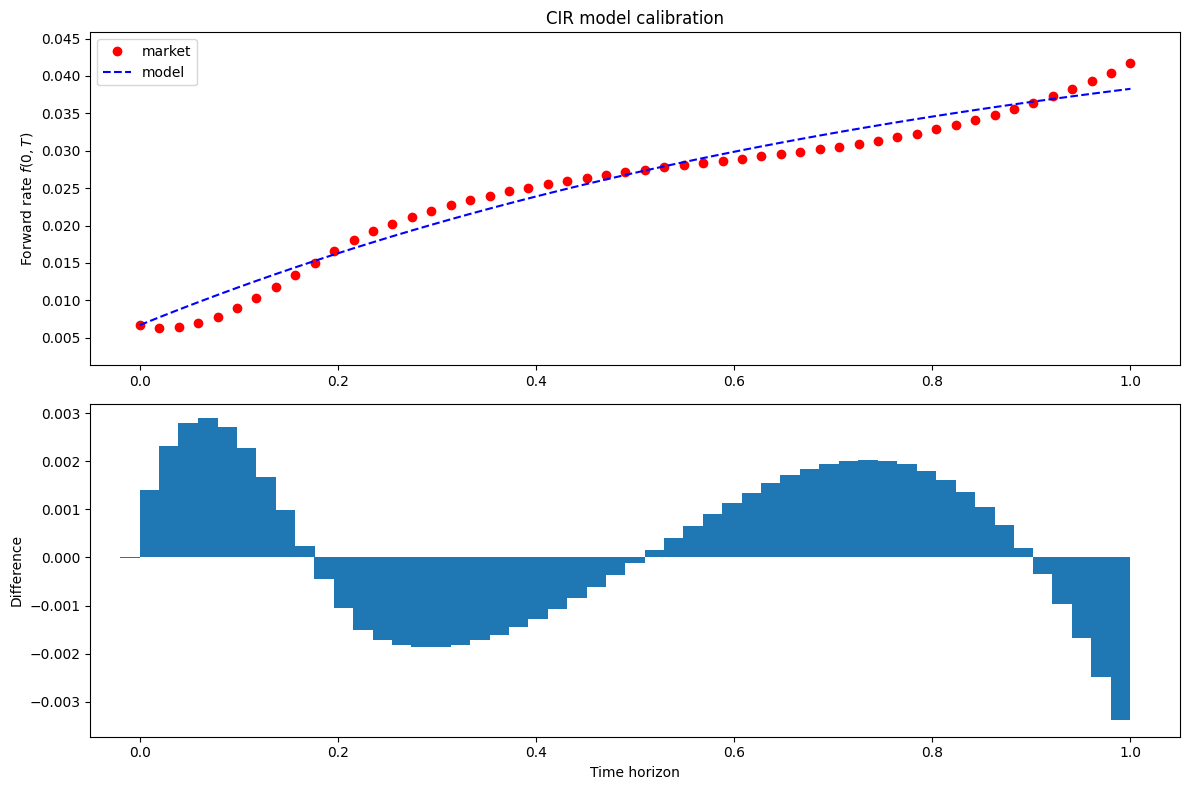

In [ ]:
def plot_calibrated_frc(opt):
    """Plots market and calibrated forward rate curves."""
    forward_rates = CIR_forward_rate(opt)
    print(forward_rates[-1])
    plt.figure(figsize=(12, 8))
    plt.subplot(211)
    plt.title("CIR model calibration")
    plt.ylabel("Forward rate $f(0,T)$")
    plt.plot(mat_list_n, f, "ro", label="market")
    plt.plot(mat_list_n, forward_rates, "b--", label="model")
    plt.legend(loc=0)
    plt.axis(
        [min(mat_list_n) - 0.05, max(mat_list_n) + 0.05, min(f) - 0.005, max(f) * 1.1]
    )
    plt.subplot(212)
    wi = 0.02
    plt.bar(mat_list_n - wi / 2, forward_rates - f, width=wi)
    plt.xlabel("Time horizon")
    plt.ylabel("Difference")
    plt.axis(
        [
            min(mat_list_n) - 0.05,
            max(mat_list_n) + 0.05,
            min(forward_rates - f) * 1.1,
            max(forward_rates - f) * 1.1,
        ]
    )
    plt.tight_layout()
plot_calibrated_frc(params)

## Step 3(b)

Given the different CIR model parameters obtained in the above step, we will now simulate Euribor 12-month rates daily for a period of 1 year by running 100,000 Monte-Carlo simulations.

In [ ]:
def cir(r0, k, theta, sigma, T, N, M):
    dt = T / N
    rates = np.zeros((N, M))
    rates[0, :] = r0
    for j in range(M):
        for i in range(1, N):
            dr = (
                k * (theta - rates[i - 1, j]) * dt
                + sigma
                * np.sqrt(dt)
                * np.sqrt(np.maximum(rates[i - 1, j], 0))
                * np.random.normal()
            )
            rates[i, j] = rates[i - 1, j] + dr
    return rates


In [ ]:
paths = 365
time = 1
k, theta, sigma = params
r0 = inter_rates[0]
rates_cir = cir(r0, k, theta, sigma, time, paths, 10**5)

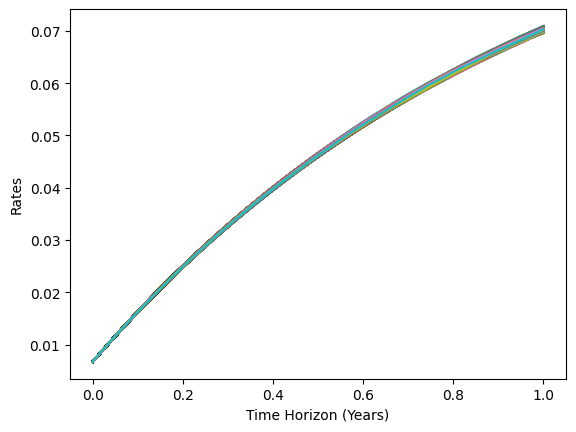

In [ ]:
xpts = np.linspace(
 0.0, time, paths
) # weekly rates
plt.plot(xpts, rates_cir)
plt.xlabel("Time Horizon (Years)")
plt.ylabel("Rates")
plt.show()

7.027773426375754 0.015259086923424602


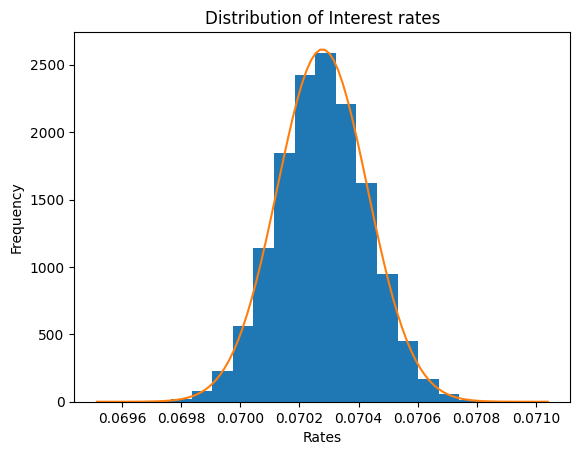

In [ ]:
import scipy.stats as stats
mean = rates_cir[-1].mean()
std = rates_cir[-1].std()
print(mean*100, std*100)
plt.hist(rates_cir[-1], bins=20, density=True)
plt.xlabel("Rates")
plt.title("Distribution of Interest rates")
plt.ylabel("Frequency")
x = np.linspace(mean - 5*std, mean + 5*std, 100)
plt.plot(x, stats.norm.pdf(x, mean, std))
plt.show()


For the above Histogram:

Mean = 7.027765140591792

Standard Deviation = 0.015170630739746541

###Step 3b(i) Select a level of confidence you are comfortable with, which is the range (min and max) that the 12-month Euribor can take in the next year?

In [ ]:
# 95% confidence interval for interest rates
print("95% confidence interval for interest rates",
 (round((mean - 2*std)*100, 2),
 round((mean + 2*std)*100, 2))
)

95% confidence interval for interest rates (7.0, 7.06)


Step 3b(ii) What is the expected value of the 12-month Euribor in 1 year?

In [ ]:
print("Expected rate", round(mean, 4), "%")

Expected rate 0.0703 %


###Step 3b(iii) How will this expected number affect the pricing of your products in 1 year versus the current 12-month Euribor rate?

When the current 12 month Euribor in 1-yr is 2.256%

In [ ]:
r = 0.02556  #When r is 2.556%
bates_put = bates_asian_opt_call(S0, S0*0.95, r, 70/250, bates_full_params_fft)
print("The Asian Put price is $%.2f" %bates_put)
#######
kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta = tuple(bates_full_params_lewis)
cp = B96_call_FFT(S0, S0*0.95, 70/250, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta)
print("The European Put price is $%.2f" % (cp + S0*0.95 * np.exp(-70/250*r) - S0))
print("European call Price $%.2f" % cp)

The Asian Put price is $4.05
The European Put price is $11.08
European call Price $24.30


When the expected 12 month Euribor in 1-yr is 7.03%

In [ ]:
r = 0.0703 #When r is 7.03%
bates_put = bates_asian_opt_call(S0, S0*0.95, r, 70/250, bates_full_params_fft)
print("The Asian Put price is $%.2f" %bates_put)
#######
kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta = tuple(bates_full_params_lewis)
cp = B96_call_FFT(S0, S0*0.95, 70/250, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta)
print("The European Put price is $%.2f" % (cp + S0*0.95 * np.exp(-70/250*r) - S0))
print("European call Price $%.2f" % cp)

The Asian Put price is $3.64
The European Put price is $9.99
European call Price $25.94


The current 12-month Euribor rate is 2.56%, while the expected 12-month Euribor rate is 7.03%. This will have an impact on the pricing of long-term European call options, which will be higher at 25.94 against 24.20. The Asian Put Price and the European Put Price will be lower at 3.64 and 9.99, respectively, compared to the current 12-month Euribor rate, which is higher at 4.02 and 11.16.


#Bibliography:
Aase, Knut K. "*Contingent Claims Valuation when the Security Price is a Combination of an Ito Process and a Random Point Process*." Stochastic Processes and their Applications, vol. 28, 1988, pp. 185-220.

Bates, David S. “*Jumps and Stochastic Volatility: Exchange Rate Processes Implicity in Deutsche Mark Options*.” Review of Financial Studies, vol. 9, no. 1, 1996, pp. 69-107

Carr, Peter, and Dilip Madan. "*Option Valuation Using the Fast Fourier Transform*." Journal of Computational Finance, vol. 2, no. 4, 1999, pp. 61-73.

Cox, J.C., J.E. Ingersoll, and S.A. Ross. "*A Theory of the Term Structure of Interest Rates*." Econometrica, vol. 53, no. 2, 1985, pp. 385-407. The Econometric Society.

Cox, John C., et al. "*An Intertemporal General Equilibrium Model of Asset Prices*." Econometrica: Journal of the Econometric Society, 1985, pp. 363-384.

Glasserman, Paul. "*Monte Carlo Methods in Financial Engineering. Springer*.", 2004.

Grant, Kenneth L. "*Quantitative Financial Analytics: The Path to Investment Profits*". McGraw-Hill, 2015.

Heston, Steven L. *A Closed-Form Solution for Options with Stochastic Volatility with Applications to Bond and Currency Options*." Review of Financial Studies, vol. 6, no. 2, 1993, pp. 327-343.

Lewis, Alan A. “*A Simple Option Formula for General Jump-Diffusion and Other Exponential Levy Processes*.” Envision Financial Systems and OptionCity.net, 2001, pp. 1-24

Merton, R. C. “*Option Pricing When Underlying Stock Returns Are Discontinuous*.” Journal of Financial Economics, vol. 3, no. 1-2, 1976, pp. 125-144
